# Overview
Vasha Dutell  
Rotation Project
Bruno Olshausen Lab  
Vision Science - UC Berkeley  

This document details the notes on the eye movement simulation project, begun by Vasha as a rotation project in the Bruno Olshausen in Fall, 2015. This is an extention to Alex Anderson's eye movement project on processing of information by the fovea, which includes data from Austin Roorda's lab, of subjects fixating on the 4-directional E, and their eye movements tracked by the AOSLO (Adaptive Optics Scanning Laser Ophthalmoscope). In creating simulated data of this task used for Alex's pipeline, the current alghrithm used for modeling eye movement is a simple diffusion model. This is an oversimplification of eye movement, and the simulated eye-movement data is easily differentiated from the real recordings. Specific differences include a sense of 'momentum' in the real recordings, which the time-step based diffusion does not retain.

# Goals
"Create a model of fixational eye movement that is 'more realistic'."  

The primary goal here is to create a simulator of fixational eye movement that resembles more closely what is seen in real data. We need to be specific here - 'real data' is what is recoreded from subjects head-mounted in the AOSLO, with a 4-directional E shape being projected on their retina while their eye position is being recorded - certainly not a 'real world' scenero. And we we must also take into account that the AOSLO does not  record eye torsion ('roll' - pupil position stays horizontal and vertical position and 'rolls' - this eye movement happens when the head is moved side to side touching eitehr ear to shoulders). The recordings have an X and Y position only (check this to make sure). Though according to Listing's law, torsion does not exist in a situation where the head is motionless.

The goal of creating a 'realistic model' may or may not mean incorporating simulation of the biologically realistic effectors of eye movement such as the 6 muscules in the eye that control eye movement/saccades. 

A first step towards this goal will be to analyze the recorded data with methods such as PCA/ICA to interpreate what components exist, and how best a model might be made.

# Advice for first steps (from Alex)

Alex has layed out these steps for getting started on the project:

1. Contact Roorda/Kavitha about artifacts in data / what would the best dataset be. **(Done 8/31, meeting 9/2)** 

2. Read some papers general background:  
-- Martinez-Conde paper on eye movements in general **read 9/1**  
-- Rucci paper on benefits of eye movements  
-- Kuang, Rucci previous paper on eye movement benefits  
-- Rucci-Nature paper on eye movements  
-- Zhang/Roorda - AOSLO basics  **read 9/2**    
-- Olshausen - do we dejitter images?  **read 9/2**  
-- Gollisch-Meister - retina smarter that we believe  
-- Engbert - another model of eye movements  

3. Understood what I was doing with kalman filter, diffusion, velocity space diffusion
-- some code
-- write up about what i was doing there  

4. understand how to load the data from the roorda lab  
-- see analyze_aoslo_large.pdf
-- some details like converting from pixels to meters...
-- some days data is better than others  

5. Understand how modeling eye movements fits into what I am doing (ask me before going over) file = em_alg_latent_feat.pdf

# Notes

A general-understanding (wikipedia) and formal literature search including the articles recommended by Alex above was performed, as well as initial meetings with Kavitha Ratnam, from the Roorda Lab, to whom this data belongs. See notes in ipython notebook below:

Link to [Eye Movement Research Notes](Eye Movement Research Notes.ipynb)

# Pipeline

Pipeline for Analysis of the AOSLO data. Adapted from Alex's pipleline

## Load Dependencies

In [155]:
import numpy as np
import os
from scipy.io import loadmat
from scipy.signal import butter, lfilter, freqz
from scipy.interpolate import interp1d
from pykalman import KalmanFilter
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Load in AOSLO Data

In [156]:
dataDir = 'data/'
files = [f for f in os.listdir(dataDir) if f.endswith('.mat')]
files

['20094L_020_cw_nostim_bandfilt_1920_hz_8199.mat',
 '20094L_022_cw_nostim_bandfilt_1920_hz_304.mat',
 '20094L_023_cw_nostim_bandfilt_1920_hz_8905.mat',
 '20094L_028_cw_nostim_bandfilt_1920_hz_7292.mat',
 '20094L_031_cw_nostim_bandfilt_1920_hz_7874.mat',
 '20094L_033_cw_nostim_bandfilt_1920_hz_237.mat']

### Examine Files
What exactly is in one of these files? Pull it into Matlab to take a look.    

Note: this is the first file, 20094L_020_cw_nostim_bandfilt_1920_hz_8199.mat.  

![fileContents1](img/fileContents1.png)
![fileContents2](img/fileContents2.png)

### Create EyeTrace class container to hold data

In [487]:
##make a class type containing the info for an eye trace

class EyeTrace:
    """A class to contain eye trace information"""
    def __init__(self, xlocs, ylocs, time, timescale):
    ##define x and y attributes
        self.x = (xlocs - xlocs[0]) * timescale ## center at start and change to arcmins
        self.y = (ylocs - ylocs[0]) * timescale ## center at start and change to arcmins
        self.time = time - time[0]
        self.scale = scale
    def x(self):
        return x
    def y(self):
        return y
    def time(self):
        return time
    def scale(self):
        return scale

In [158]:
#Just load in one file for now while we play and get the pipeline down.
#nfile = 0
#trials = list()
#for nfile in range(0,len(files)-1):
#    trial = loadmat(os.path.join(data_dir, files[nfile]))
#    trials.append(trial)
#    t = trial['timeaxis_secs'][:,0] ##extract time axis (1920 frames)
#    t = t-t[0] ##start at time zero
#    xy = trial['frameshifts_strips_spline'] * scale
#    x = trial['frameshifts_strips_spline'][:, 0] * scale
#    y = trial['frameshifts_strips_spline'][:, 1] * scale
#    x = x - x[0] ##center x at start
#    y = y - y[0] ##center y at start

Creating the scale: 392 pixels per degree, and 60 arcminutes per degree. I think this is specific to the given file? Need to double check with Alex on this one. AND make sure that he knows files are 0 indexed, so 392 goes with the second file in the list.

In [159]:
scale = 1. / 392. * 60. # Conversion from pixels to arcmins

### Loop through & Load 
Now load in each of our files, with each trial being initiated as a member of our EyeTrace class, and put in the vector trials

In [494]:
trials = []
for fh in files:
    nfile = loadmat(os.path.join(dataDir, fh))
    x = nfile['frameshifts_strips_spline'][:, 0] 
    y = nfile['frameshifts_strips_spline'][:, 1] 
    t = nfile['timeaxis_secs'][:,0] ##extract time axis (1920 frames)
    trial = EyeTrace(x, y, t, scale)
    trials.append(trial)

len(trials)

6

## Explore Pre-Filtered Data

### Plot Trajectories - x and y separately

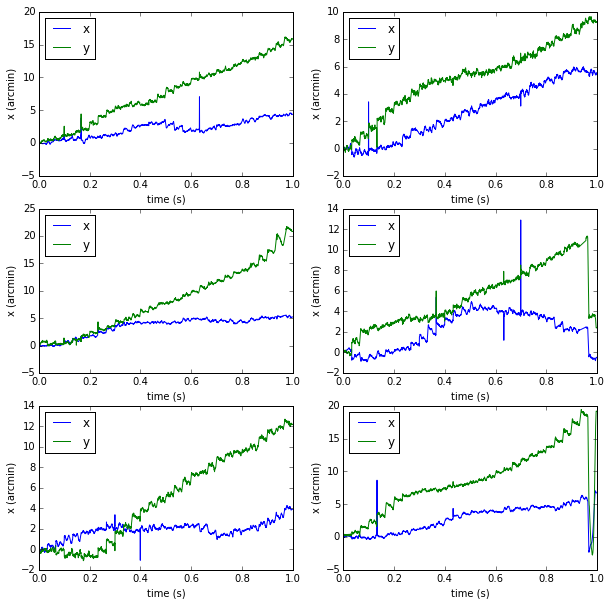

In [164]:
import math

##calc number of rows needed with 2 cols
ncol = 2
nrow = int(math.ceil(len(trials) / ncol))

fig, ax = plt.subplots(nrow,ncol, figsize=(10,10))
for i, pl in enumerate(ax.flatten()):
    trial = trials[i]
    pl.plot(trial.time, trial.x, label = 'x')
    pl.plot(trial.time, trial.y, label = 'y')
    pl.set_xlabel('time (s)')
    pl.set_ylabel('x (arcmin)')
    pl.legend(loc = 0)
plt.show()
   

### Plot Trajectories - x and y together

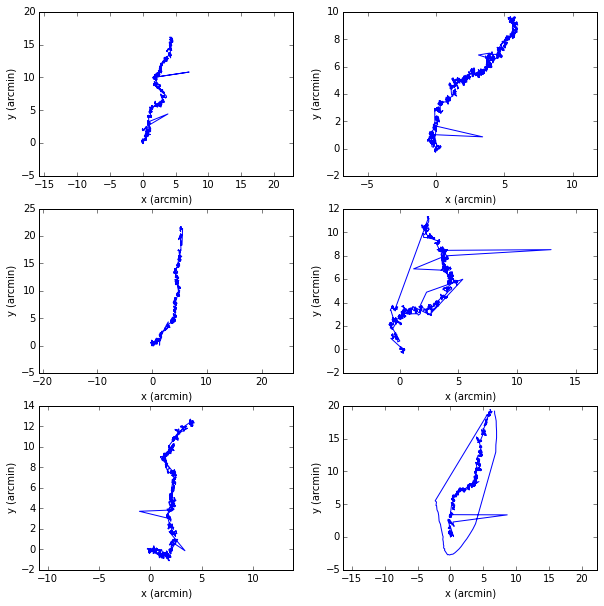

In [165]:
fig, ax = plt.subplots(nrow,ncol, figsize=(10,10))
for i, pl in enumerate(ax.flatten()):
    trial = trials[i]
    pl.plot(trial.x, trial.y)
    pl.set_xlabel('x (arcmin)')
    pl.set_ylabel('y (arcmin)')
    pl.axis('equal')
plt.show()w

### Plot Trajectories - x and y togeter with timecourse

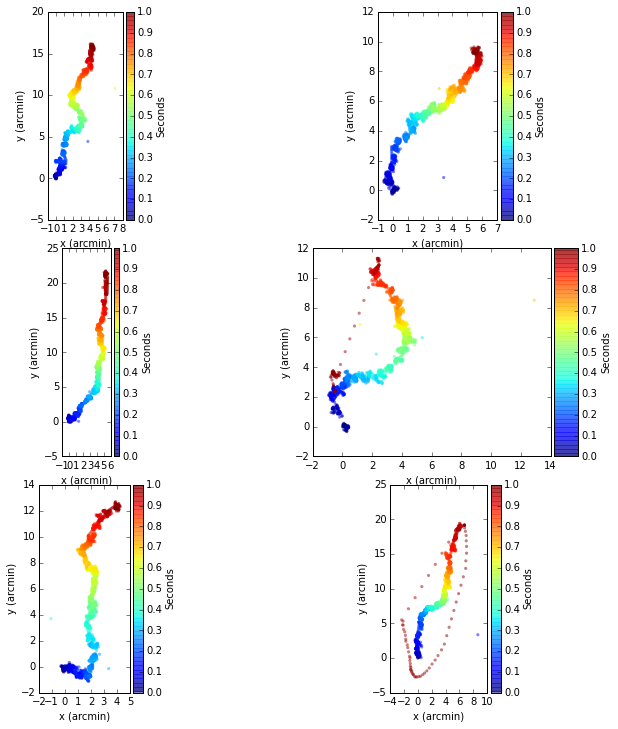

In [167]:
import numpy as np
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

#Show early -> late progression
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))
plt.tight_layout()

for i, pl in enumerate(ax.flatten()):
    trial = trials[i]
    im = pl.scatter(trial.x, trial.y, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x (arcmin)')
    pl.set_ylabel('y (arcmin)')
    pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('Seconds')

plt.show()

## Filtering

There are jumps in the data. We should smooth them out using a filter.  

Lets return to this in the future. Also look at implementing specifically the Kalmann smoothing which takes into account t-1 (past) and t+1 (future) events instead of the Kalmann filter that only uses previous timepoints when estimating position and velocity.  

Let's return to this after replicating the K&H paper.  

Note: We should know from the specs of the AOSLO what our expected error is. 

##  Plot FFT & Power Spectrum
Let's see what the power spectrum looks like for this data. Then try to combine samples and calculate.

### Alex's Method - Power Spectrum

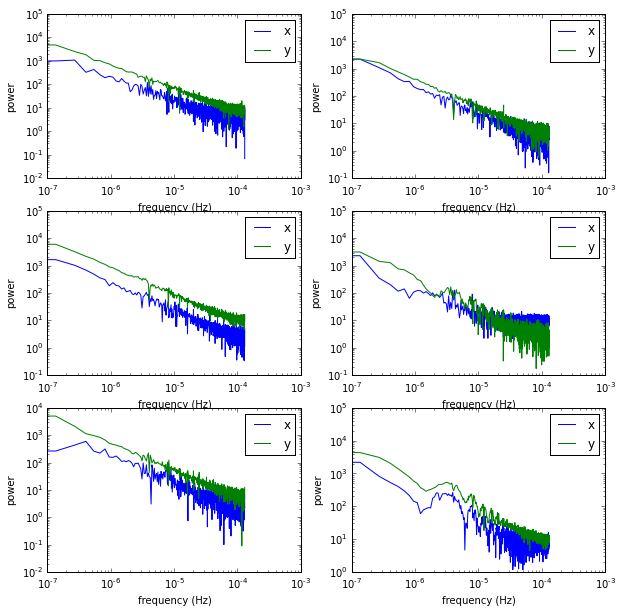

In [279]:
import numpy as np
from scipy.fftpack import fft

fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))
tstep = float(2*len(trials[0].x)) #this is the Nyquist frequency (2x sampling rate)

for i, pl in enumerate(ax.flatten()):
    trial = trials[i]
    
    #X direction
    xfq = np.fft.fftshift(np.fft.fftfreq(len(trial.x), tstep))
    xps = np.fft.fftshift(np.abs(np.fft.fft(trial.x)))
    #Y direction
    yfq = np.fft.fftshift(np.fft.fftfreq(len(trial.y), tstep))
    yps = np.fft.fftshift(np.abs(np.fft.fft(trial.y)))
    ##plot it
    pl.plot(xfq, xps, label = 'x')
    pl.plot(yfq, yps, label = 'y')
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')
    ##labels
    pl.set_xlabel('frequency (Hz)')
    pl.set_ylabel('power')
    ##legend
    pl.legend(loc = 0)
plt.show()


There don't appear to be any strong frequencies in the eye-movement data.

### My own implementation

adapted from: http://snowball.millersville.edu/~adecaria/ESCI386P/esci386-lesson17-Fourier-Transforms.pdf

#### Power Spectrum Only

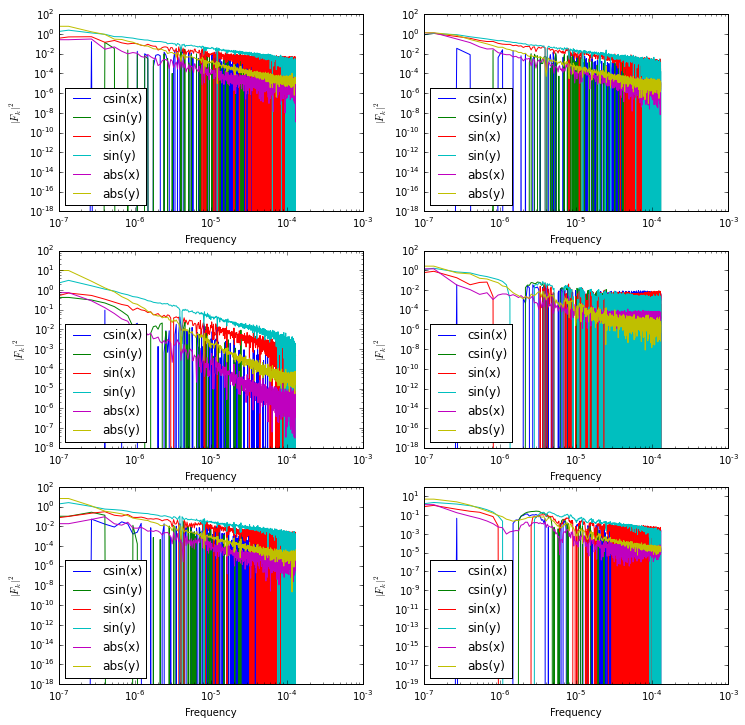

In [262]:
import numpy as np
from scipy.fftpack import fft

fig, ax = plt.subplots(nrow, ncol, figsize=(12,12)) #, sharex = True )
tstep = float(2*len(trials[0].x)) #this is the Nyquist frequency (2x sampling rate)

##calc number of rows needed with 2 cols (one for each of re/im/mag part of FFT)
ncol = 2
nrow = int(math.ceil(len(trials) / ncol))

for i, pl in enumerate(ax.flatten()):
    trial = trials[i]
    #X direction
    xnu = np.fft.fftshift(np.fft.fftfreq(len(trial.x),tstep))
    xfq = np.fft.fftshift(np.fft.fft(trial.x)/len(trial.x))
    xfqre = np.real(xfq) #real terms (cosine)
    xfqim = np.imag(xfq) #imaginary terms (sine)
    xfqabs = np.absolute(xfq**2) #spectral power
    #Y direction
    ynu = np.fft.fftshift(np.fft.fftfreq(len(trial.y),tstep))
    yfq = np.fft.fftshift(np.fft.fft(trial.y)/len(trial.y))
    yfqre = np.real(yfq) #real terms (cosine)
    yfqim = np.imag(yfq) #imaginary terms (sine)
    yfqabs = np.absolute(yfq**2) #spectral power

    ##plot real (cosine)
    pl.plot(xnu, xfqre, label = 'csin(x)')
    pl.plot(ynu, yfqre, label = 'csin(y)')
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')
    ##labels
    pl.set_xlabel('Frequency')
    pl.set_ylabel(r'$Re[F_k]$')

    ##legend
    #pl.legend(loc = 0)    
    
    ##plot imaginary (sine)
    pl.plot(xnu, xfqim, label = 'sin(x)')
    pl.plot(ynu, yfqim, label = 'sin(y)')
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')
    ##labels
    pl.set_xlabel('Frequency')
    pl.set_ylabel(r'$Im[F_k]$')
    ##legend
    #pl.legend(loc = 0)   
    
    ##plot spectral power (magnitude)
    pl.plot(xnu, xfqabs, label = 'abs(x)')
    pl.plot(ynu, yfqabs, label = 'abs(y)')
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')
    ##labels
    pl.set_xlabel('Frequency')
    pl.set_ylabel(r'$\vert F_k \vert ^2$')
    ##legend
    pl.legend(loc = 0)   
    
#fig.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in fig.axes[:-3]], visible=False)    
plt.show()


In [302]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 100;

<IPython.core.display.Javascript object>

#### Separate imaginary, real, and magnitude

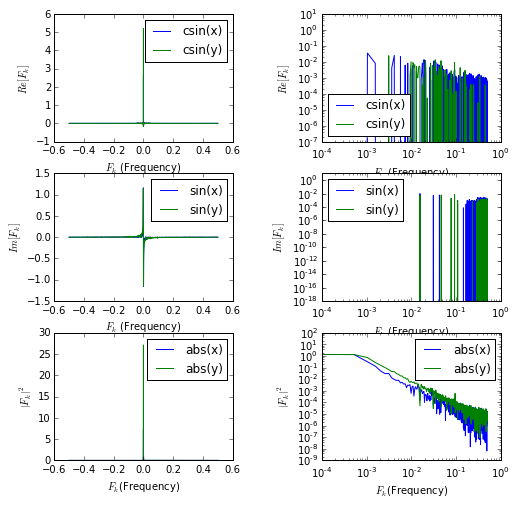

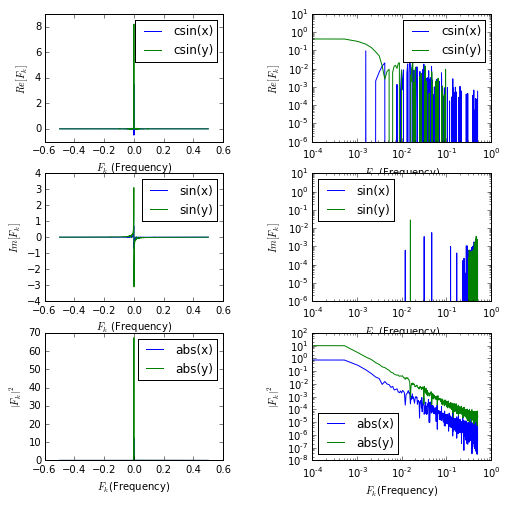

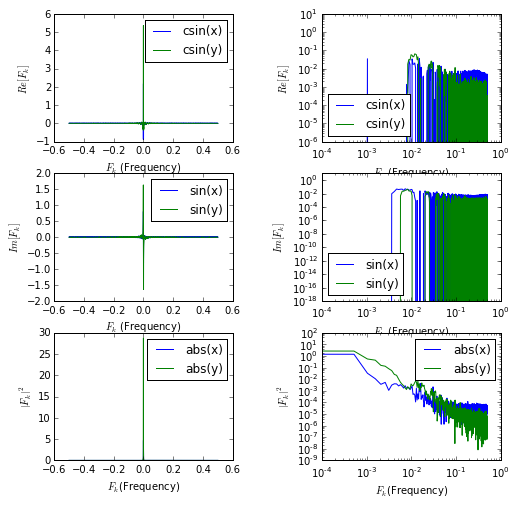

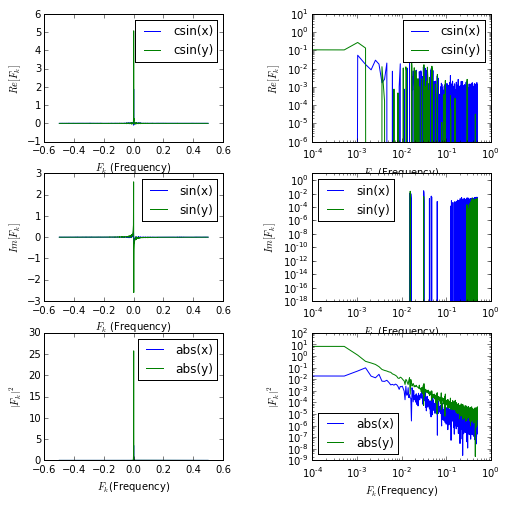

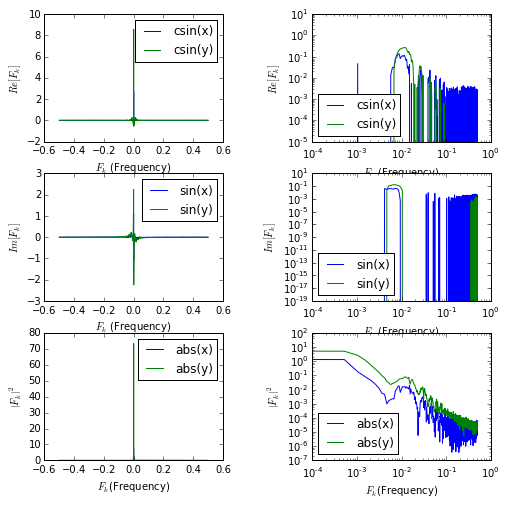

In [283]:
import numpy as np
from scipy.fftpack import fft

tstep = 1/float(2*len(trials[0].x))-1 #this is the Nyquist frequency (2x sampling rate)
#tstep = 10

##calc number of rows needed with 2 cols (one for each of re/im/mag part of FFT)
ncol = 2
nrow = int(math.ceil(len(trials) / ncol))

for i in range(1,len(trials)):
    trial = trials[i]
    
    #X direction
    xnu = np.fft.fftshift(np.fft.fftfreq(len(trial.x), tstep))
    xfq = np.fft.fftshift(np.fft.fft(trial.x)/len(trial.x))
    xfqre = np.real(xfq) #real terms (cosine)
    xfqim = np.imag(xfq) #imaginary terms (sine)
    xfqabs = np.absolute(xfq**2) #spectral power
    #Y direction
    ynu = np.fft.fftshift(np.fft.fftfreq(len(trial.y), tstep))
    yfq = np.fft.fftshift(np.fft.fft(trial.y)/len(trial.y))
    yfqre = np.real(yfq) #real terms (cosine)
    yfqim = np.imag(yfq) #imaginary terms (sine)
    yfqabs = np.absolute(yfq**2) #spectral power

    fig, ax = plt.subplots(3,2, figsize=(8,8), sharex = False )
    
    ##non-logged
    ##plot real (cosine)
    ax[0,0].plot(xnu, xfqre, label = 'csin(x)')
    ax[0,0].plot(ynu, yfqre, label = 'csin(y)')
    ##labels
    ax[0,0].set_xlabel('$F_k$ (Frequency)')
    ax[0,0].set_ylabel(r'$Re[F_k]$')
    ##legend
    ax[0,0].legend(loc = 0)    
    
    ##plot imaginary (sine)
    ax[1,0].plot(xnu, xfqim, label = 'sin(x)')
    ax[1,0].plot(ynu, yfqim, label = 'sin(y)')
    ##labels
    ax[1,0].set_xlabel('$F_k$ (Frequency)')
    ax[1,0].set_ylabel(r'$Im[F_k]$')
    ##legend
    ax[1,0].legend(loc = 0)   
    
    ##plot spectral power (magnitude)
    ax[2,0].plot(xnu, xfqabs, label = 'abs(x)')
    ax[2,0].plot(ynu, yfqabs, label = 'abs(y)')
    ##labels
    ax[2,0].set_xlabel('$F_k$(Frequency)')
    ax[2,0].set_ylabel(r'$\vert F_k \vert ^2$')
    ##legend
    ax[2,0].legend(loc = 0)   
    
    
    ##log scale
    
    ##plot real (cosine)
    ax[0,1].plot(xnu, xfqre, label = 'csin(x)')
    ax[0,1].plot(ynu, yfqre, label = 'csin(y)')
    ##log scale
    ax[0,1].set_xscale('log')
    ax[0,1].set_yscale('log')
    ##labels
    ax[0,1].set_xlabel('$F_k$ (Frequency)')
    ax[0,1].set_ylabel(r'$Re[F_k]$')
    ##legend
    ax[0,1].legend(loc = 0)    
    
    ##plot imaginary (sine)
    ax[1,1].plot(xnu, xfqim, label = 'sin(x)')
    ax[1,1].plot(ynu, yfqim, label = 'sin(y)')
    ##log scale
    ax[1,1].set_xscale('log')
    ax[1,1].set_yscale('log')
    ##labels
    ax[1,1].set_xlabel('$F_k$ (Frequency)')
    ax[1,1].set_ylabel(r'$Im[F_k]$')
    ##legend
    ax[1,1].legend(loc = 0)   
    
    ##plot spectral power (magnitude)
    ax[2,1].plot(xnu, xfqabs, label = 'abs(x)')
    ax[2,1].plot(ynu, yfqabs, label = 'abs(y)')
    ##log scale
    ax[2,1].set_xscale('log')
    ax[2,1].set_yscale('log')
    ##labels
    ax[2,1].set_xlabel('$F_k$(Frequency)')
    ax[2,1].set_ylabel(r'$\vert F_k \vert ^2$')
    ##legend
    ax[2,1].legend(loc = 0)   
    
    ##tidy up
    fig.subplots_adjust(hspace=.25, wspace=.5)
    #plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    
plt.show()


## Reproduce Engbert & Kliegl, 2004

A first step is to reproduce what was done by the Engbert & Kliegl, 2004 paper. See notes here in Modeling section of: [Eye Movement Research Notes: Engbert & Kliegl, 2004](Eye Movement Research Notes.ipynb)  

A brief overview:  

*  Measure temporal evolution of mean square displacement $(\Delta x^2)$ from FBM equation for eye movement: $(\Delta x^2) \propto \Delta t^H$. Use experimental data to calculate $H$ as slope of log-log plot of equation for mean square displacement: $D^2 $ over time $t$ for each time step using equation: $$ D^2 (m) = \frac{1}{N-m}\sum_{i=1}^{N-m}\|{\vec{x}_{i+m} - \vec{x}_i}\|^2$$ where $N$ is number of samples in recorded time series, $m$ is time lag measured as number of data samples.  



*  Sew together time courses without microsaccades and test $H$ again. We have already eliminated microsaccades - or so we think. Some samples we have already looked at contain large jumps. May want to reevaluate these jumps in the future, make sure we are still looking at ONLY drift.

### Relative displacement at each timepoint from last timepoint

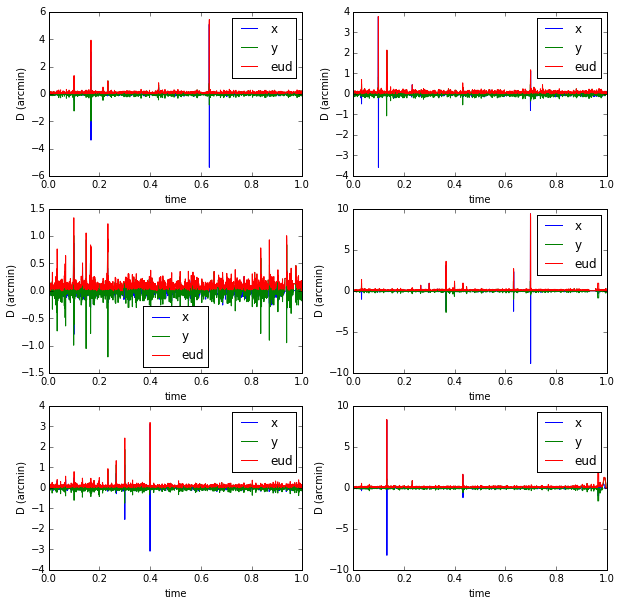

In [428]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10)) #, sharex = True )

##calc number of rows needed with 2 cols (one for each of re/im/mag part of FFT)
ncol = 2
nrow = int(math.ceil(len(trials) / ncol))

for i, pl in enumerate(ax.flatten()):

    trial = trials[i]

    ##the displacement is t+1 - t
    xt1 = trial.x[:len(trial.x)-1]
    xt2 = trial.x[1:]
    #xd = xt2-xt1 ##THIS IS WRONG!!!
    xd = [xt2_i - xt1_i for xt2_i, xt1_i in zip(xt2, xt1)]
    yt1 = trial.y[:len(trial.y)-1]
    yt2 = trial.y[1:]
    #yd = yt2-yt1 ##THIS IS WRONG!!!
    yd = [yt2_i - yt1_i for yt2_i, yt1_i in zip(yt2, yt1)]
    type(yd)
    xd2 = [i**2 for i in xd]
    yd2 = [i**2 for i in yd]
    eud = [sum(i) for i in zip(xd2, yd2)]
    eud = [i**.5 for i in eud]
    
    pl.plot(trial.time[1:], xd, label = 'x')
    pl.plot(trial.time[1:], yd, label = 'y')
    pl.plot(trial.time[1:], eud, label = 'eud')
    
    #pl.set_xscale('log')
    #pl.set_yscale('log')
    
    pl.set_xlabel('time')
    pl.set_ylabel('D (arcmin)')


    pl.legend(loc = 0)    

The single frame displacements seem to really mess us up. This is a good reason to pre-filter to remove these large outliers.

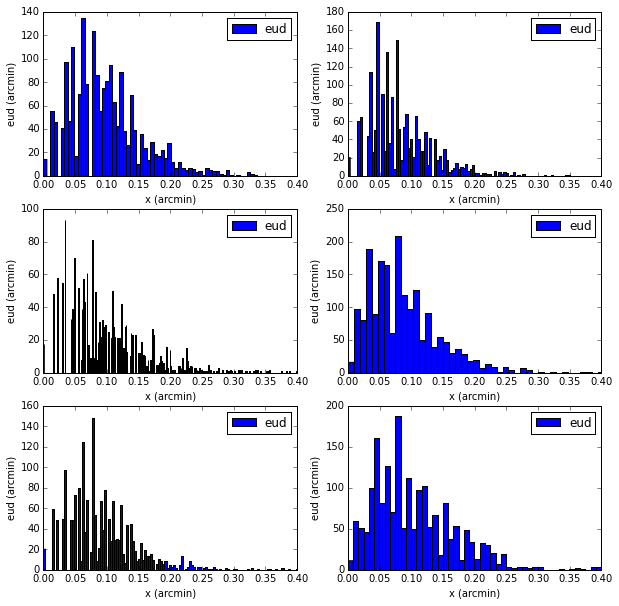

In [429]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10)) #, sharex = True )

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trials) / ncol))

for i, pl in enumerate(ax.flatten()):

    trial = trials[i]

    ##the displacement is t+1 - t
    xt1 = trial.x[:len(trial.x)-1]
    xt2 = trial.x[1:]
    #xd = xt2-xt1 ##THIS IS WRONG!!!
    xd = [xt2_i - xt1_i for xt2_i, xt1_i in zip(xt2, xt1)]
    
    yt1 = trial.y[:len(trial.y)-1]
    yt2 = trial.y[1:]
    #yd = yt2-yt1 ##THIS IS WRONG!!!
    yd = [yt2_i - yt1_i for yt2_i, yt1_i in zip(yt2, yt1)]
    
    xd2 = [i**2 for i in xd]
    yd2 = [i**2 for i in yd]
    eud = [sum(i) for i in zip(xd2, yd2)]
    eud = [i**.5 for i in eud]

    pl.hist(eud, 1000, label = 'eud')
    pl.set_xlim((0,.4))
    
    #pl.set_xscale('log')
    #pl.set_yscale('log')
    
    pl.set_xlabel('x (arcmin)')
    pl.set_ylabel('y (arcmin)')
    pl.set_ylabel('eud (arcmin)')

    pl.legend(loc = 0)    

Interestingly, these distributions look like Poissons. This implies that there is a preference for NOT keeping the same position from timepoint to timepoint. Either that or because the machine goes out to so many decimal points, uncertainty in the machine is much higher than the measurement. Or something else? This is a good question for Kavitha.

### Overall Displacement
Now take t=0 as position zero, and calculate the displacement over time, with each timepoint relative to t=0

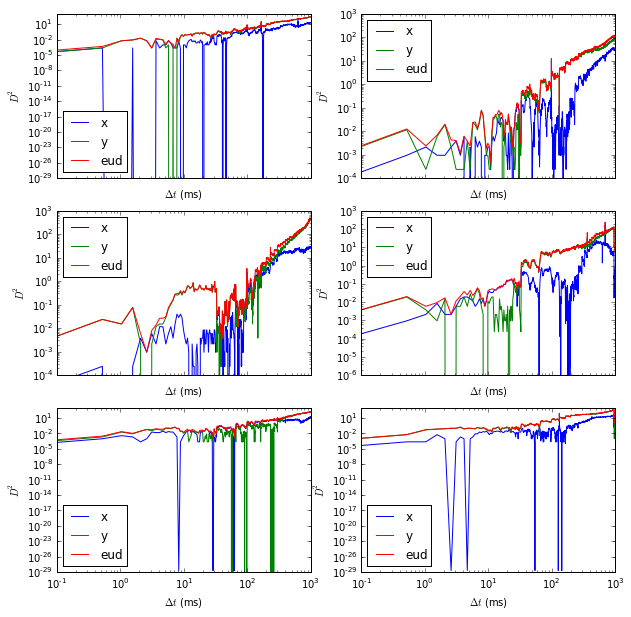

In [427]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trials) / ncol))

for i, pl in enumerate(ax.flatten()):

    trial = trials[i]
    
    ##our values for trial.x are already relative to t=0.
    ##calculate euclidian dist = sqrt((x2-x1)^2 + (y2-y1)^2)
    xd2 = [i**2 for i in trial.x]
    yd2 = [i**2 for i in trial.y]
    eud = [sum(i) for i in zip(xd2, yd2)]
    eud = [i**.5 for i in eud]
    ##calcualte distance squared.
    eud2 = [i**2 for i in eud]

    pl.plot(trial.time*1000, xd2, label= 'x')
    pl.plot(trial.time*1000, yd2, label= 'y')
    pl.plot(trial.time*1000, eud2, label= 'eud')
    
    pl.set_xscale('log')
    pl.set_yscale('log')

    pl.set_xlabel('$\Delta t$ (ms)')
    pl.set_ylabel('$D^2$')
    
    pl.legend(loc = 0)

#fig.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)

Note: We don't start at zero because we are in log scale, just as in Fig2 in E&K.  

However, we see something different here, large drops to zero in the middle. Sample 3 can serve as an example of a relatively 'clean' sample, as seen in: [trajectory plot](### Plot Trajectories - x and y togeter with timecourse), yet we still see these large drops. Maybe something is wrong?

### Total Cumulative Displacement
Now take t=0 as position zero, and calculate the total displacement over time, exactly as in the paper, with the equation: $$ D^2 (m) = \frac{1}{N-m}\sum_{i=1}^{N-m}\|{\vec{x}_{i+m} - \vec{x}_i}\|^2$$ That is, by summing over the total displacement over the timecourse up until $t$.

Perform this calculation of summation of displacement *after* the calculation of euclidian distance.

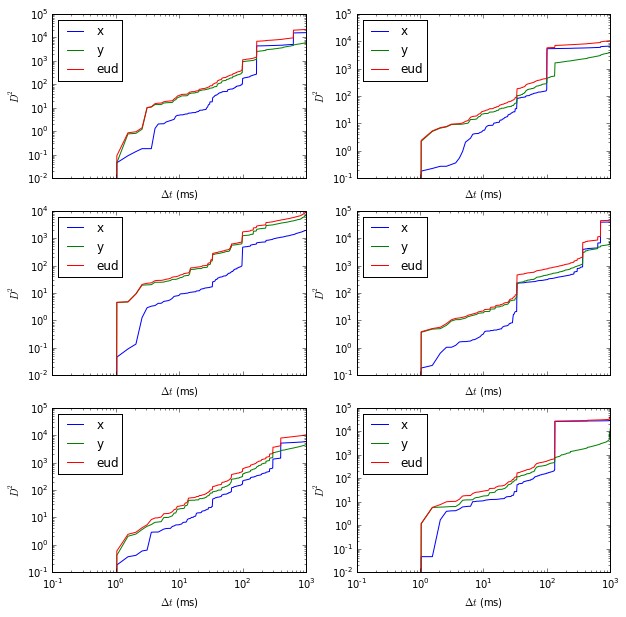

In [461]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trials) / ncol))

for i, pl in enumerate(ax.flatten()):

    trial = trials[i]
    
    ##the individual displacement for timepoint t is  value(t+1) - value(t)
    ##x
    xt1 = trial.x[:len(trial.x)-1]
    xt2 = trial.x[1:]
    xd = [xt2_i - xt1_i for xt2_i, xt1_i in zip(xt2, xt1)]
    xd2 = [i**2 for i in xd] ##squared distance
    ##y
    yt1 = trial.y[:len(trial.y)-1]
    yt2 = trial.y[1:]
    yd = [yt2_i - yt1_i for yt2_i, yt1_i in zip(yt2, yt1)]
    yd2 = [i**2 for i in yd] ##squared distance
    ##euclidian distnace
    eud = [sum(i) for i in zip(xd2, yd2)]
    eud = [i**.5 for i in eud]
    ##calcualte euclidian distance squared.
    eud2 = [i**2 for i in eud]
    
    ##now need to cumulatively sum each of these individual displacements over all the displacements that preceeded it.
    xdcm = [sum(xd2[:i]) for i in range(len(xd2))]
    ydcm = [sum(yd2[:i]) for i in range(len(yd2))]
    eudcm = [sum(eud2[:i]) for i in range(len(eud2))]

    ##normalize by timepoint for each m (how long it's been)
    xdcmnorm = [len(xdcm) - i for i in trial.time]
    xdcmnorm = [0.1 * float(i) for i in xdcmnorm]
    ydcmnorm = [len(ydcm) - i for i in trial.time]
    ydcmnorm = [0.1 * float(i) for i in ydcmnorm]
    eudcmnorm = [len(eudcm) - i for i in trial.time]
    eudcmnorm = [0.1 * float(i) for i in eudcmnorm]
    
    xdcm = [i * j for i, j in zip(xdcmnorm, xdcm)]
    ydcm = [i * j for i, j in zip(ydcmnorm, ydcm)]
    eudcm = [i * j for i, j in zip(eudcmnorm, eudcm)]
    
    #xdcm2 = [i**2 for i in xdcm]
    #ydcm2 = [i**2 for i in ydcm]
    #eudcm2 = [i**2 for i in eudcm]
    
    pl.plot(trial.time[1:]*1000, xdcm, label= 'x')
    pl.plot(trial.time[1:]*1000, ydcm, label= 'y')
    pl.plot(trial.time[1:]*1000, eudcm, label= 'eud')
    
    pl.set_xscale('log')
    pl.set_yscale('log')

    pl.set_xlabel('$\Delta t$ (ms)')
    pl.set_ylabel('$D^2$')
    
    pl.legend(loc = 0)

#fig.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)

#### I think the following is garbage, but leave it just in case it's not.

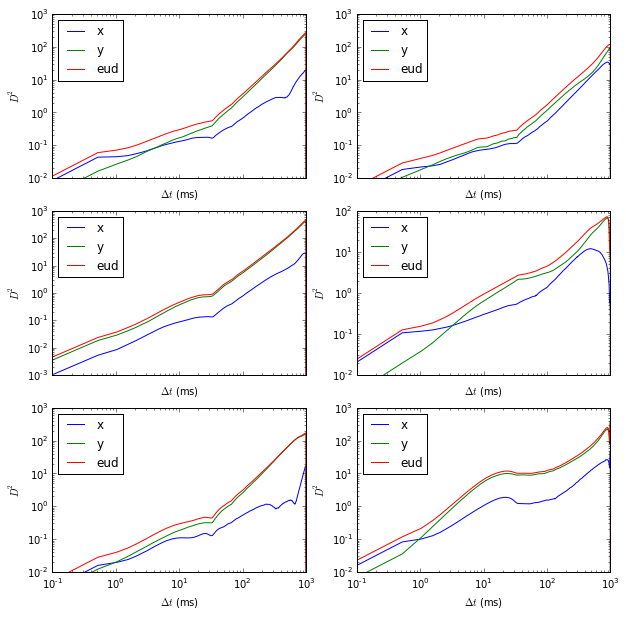

In [505]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trials) / ncol))

for i, pl in enumerate(ax.flatten()):
    trial = trials[i]

    xdist = np.zeros(len(trial.x))
    ydist = np.zeros(len(trial.y))
    eudist = np.zeros(len(trial.x))
    
    for m in range(0,len(trial.x)-1):
        
        ##x
        xim = trial.x[m:]
        xi = trial.x[:-m]
        xd = [(ximi - xii)**2 for ximi, xii in zip(xim, xi)]
        xdist[m] = sum(xd)/(len(trial.x)-m)
        
        ##y
        yim = trial.y[m:]
        yi = trial.y[:-m]
        yd = [(yimi - yii)**2 for yimi, yii in zip(yim, yi)]
        ydist[m] = sum(yd)/(len(trial.y)-m)
    
        ##euclidian
        #xd2 = [i**2 for i in xd]
        #yd2 = [i**2 for i in yd]
        eud = [np.sqrt(xd2i + yd2i)**2 for xd2i, yd2i in zip(xd, yd)]
        eudist[m] = sum(eud)/(len(trial.x)-m)
    
    pl.plot(trial.time*1e3, xdist, label= 'x')
    pl.plot(trial.time*1e3, ydist, label= 'y')
    pl.plot(trial.time*1e3, eudist, label= 'eud')
    pl.plot(, eudist, label= 'D=$\Delta(t)$')

    
    pl.set_xscale('log')
    pl.set_yscale('log')

    pl.set_xlabel('$\Delta t$ (ms)')
    pl.set_ylabel('$D^2$')
    
    pl.legend(loc = 0)

#fig.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)

#### A second try at implementation - using numpy arrays

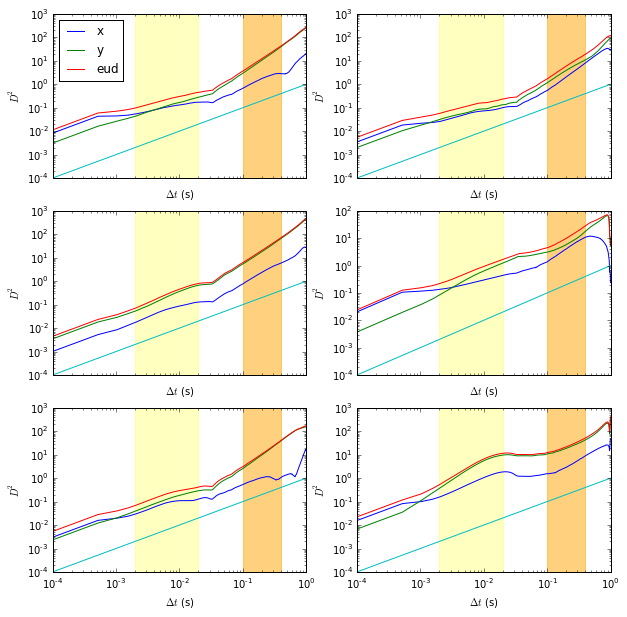

In [566]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trials) / ncol))

##iterate over all trials
for i, pl in enumerate(ax.flatten()):
    trial = trials[i]

    ##initiate the numpy arrays that will hold the values we use
    xdist = np.zeros(len(trial.x))
    ydist = np.zeros(len(trial.y))
    assert(len(trial.x)==len(trial.y))
    eudist = np.zeros(len(trial.x))
    
    ##iterate over all values of m (aka'lag time')
    for m in range(1,len(trial.x)):
        
        ##x
        xim = trial.x[m:]
        xi = trial.x[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        xd = np.mean((xim - xi)**2)
        xdist[m] = xd
        
        ##y
        yim = trial.y[m:]
        yi = trial.y[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        yd = np.mean((yim - yi)**2)
        ydist[m] = yd
        
        ##euclidian
        ##don't need to calculate square of sqare root (for euclidian dist)
        eud = np.mean(xd + yd) 
        eudist[m] = eud
    
    ##plot x, y, and eud
    pl.plot(trial.time, xdist, label= 'x')
    pl.plot(trial.time, ydist, label= 'y')
    pl.plot(trial.time, eudist, label= 'eud')
    
    ##also plot limits in E&K paper
    ##2ms start, 20ms end of Hs < 1
    pl.axvspan(.002, .02, alpha=0.25, color='yellow')
    #pl.axvline(.002, color = 'orange')
    #pl.axvline(.02, color = 'orange')
    ##100ms start, 400ms end Hl > 1
    pl.axvspan(.1, .4, alpha=0.5, color='orange')
    ##old method
    #pl.axvline(.1, color = 'purple')
    #pl.axvline(.4, color = 'purple')
    
    
    ##also plot line for scaling exponent H = 1
    pl.plot(trial.time, trial.time)
    
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')

    ##labels
    pl.set_xlabel('$\Delta t$ (s)')
    pl.set_ylabel('$D^2$')
    
    ##legend on first graph only
    if(i==0):
        pl.legend(loc = 0)

##extra code for making graphs pretty - don't use now.
#fig.subplots_adjust(hspace=0)a
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)




Wow! we get the same result as the other case. We may be doing something correctly here.  

Interstingly, in our data we actually see an INCREASE in rate of displacement increase (scaling factor H) for larger lag times, specifically between 10 and 100 seconds, and more specifically ~20-30 secs. There is a knee in the curve at one of these times, and the displacement increases significantly.  

Compare this with the graph from the Engbert & Kliegl paper, where we see a decrease in displacement increase (value of H) at around 30ms.  

![eandkpaper](img/ekgraph.png)

Before we get too excited though, a couple points to consider:  

* The E&K experiment is different than ours, in a lot of ways.  
    * Their data is taken from an EyeLinkII system, ours from an AOSLO.  
    * Sampling frequency for E&K is 100Hz, ours at 40Hz. This is particularly important because at 40Hz, the Hs measured from 2-20ms, consists of 18ms, or only .72 frames (=40*.018) in our experiment. Not really enough to tell. Wheras in the E&K experiment, the 18ms window is measured  9 frames (=500*.015). The situation is better for the Hl measured from 100-400ms consists of 300ms, or 12 (=40*.3) in our experiment, and 150 (=500*.3) in E&K.
    * E&K experiment INCLUDES microsaccades, which we specifically EXCLUDE.  

* We still have not filtered our data. Though it seems unlikely, perhaps these outliers we need to filter out are affecting our results.


In [512]:
ydist

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

## Chain together trials and plot position
Can't do FFT or power spectrum here, because chaining would mess up freqnecy.

